## **GROUP MEMBER**
#### 1. Zhao Geping
#### 2. Lu TingJia (Tikko)
#### 3. Zhang Yonghan 
#### 4. Wong Jia Shing (Emily)
#### 5. Nguyen Thanh Binh

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf
import datetime as dt

In [2]:
def extract_price_level(df: pd.DataFrame, price: str = "Close") -> pd.DataFrame:
    """
    From a DataFrame whose columns are a MultiIndex [Price, Ticker],
    extract just the given price level and return a flat DataFrame
    whose columns are the tickers.
    """
    if not isinstance(df.columns, pd.MultiIndex):
        raise ValueError("`df.columns` must be a MultiIndex with levels ['Price','Ticker']")
    out = df.xs(price, axis=1, level="Price")
    return out.reindex(sorted(out.columns), axis=1)


def data_YFinance(tickers: list[str], start: str, end: str, interval: str = "1d", price: str = "Close") -> pd.DataFrame:
    """
    Download data for multiple tickers from yfinance and extract a single price level.

    Parameters
    ----------
    tickers : list of str
        e.g. ['BTC-USD', 'ETH-USD', 'ADA-USD']
    start : str (YYYY-MM-DD)
        e.g. '2020-01-01'
    end : str (YYYY-MM-DD)
        e.g. '2021-01-01'
    interval : str, default '1d'
        Data granularity: '1d','1h','30m', etc.
    price : str, default 'Close'
        Which column to extract: 'Open','High','Low','Close','Volume', etc.

    Returns
    -------
    pd.DataFrame
        Date‐indexed, columns = tickers, containing the requested price series.
    """
    # 1) Download into a MultiIndex‐column DataFrame: (Price, Ticker)
    raw = yf.download(tickers=tickers, start=start, end=end, interval=interval, group_by="column",
                      auto_adjust=False, threads=True, progress=False)

    # 2) Extract only the requested price‐level
    price_df = extract_price_level(raw, price)

    return price_df

In [3]:
from sklearn.linear_model import LinearRegression

def strategy_performance(df: pd.DataFrame,
                         strat_ret_col: str = 'strategy_ret',
                         trading_days: int = 252,
                         risk_free: float = 0.0,
                         market_returns: pd.Series = None,
                         plot: bool = False) -> tuple[pd.DataFrame, pd.DataFrame]:

    # --- Create base performance table ---
    perf_df = pd.DataFrame(index=df.index)
    perf_df['strategy_ret'] = df[strat_ret_col]
    perf_df['cum_factor'] = (1 + perf_df['strategy_ret']).cumprod()
    perf_df['cum_return'] = perf_df['cum_factor'] - 1
    perf_df['high_watermark'] = perf_df['cum_factor'].cummax()
    perf_df['drawdown'] = (perf_df['cum_factor'] - perf_df['high_watermark']) / perf_df['high_watermark']
    max_dd = perf_df['drawdown'].min()

    # --- Annualized Stats ---
    mean_ret = perf_df['strategy_ret'].mean()
    std_ret = perf_df['strategy_ret'].std()
    total_ret = perf_df['cum_return'].iloc[-1]
    ann_return = mean_ret * trading_days
    ann_std = std_ret * np.sqrt(trading_days)
    daily_rf = risk_free / trading_days
    ann_sharpe = ((mean_ret - daily_rf) / std_ret) * np.sqrt(trading_days) if std_ret else np.nan

    # --- Market-related metrics ---
    beta = alpha = treynor = market_cum_ret = np.nan
    if market_returns is not None:
        # Align data
        aligned = df[[strat_ret_col]].join(market_returns.rename('market')).dropna()
        X = aligned[['market']].values
        y = aligned[strat_ret_col].values
        model = LinearRegression().fit(X, y)
        beta = model.coef_[0]
        alpha = model.intercept_ * trading_days  # annualized alpha
        market_cum_ret = (1 + aligned['market']).prod() - 1
        if beta != 0:
            treynor = (ann_return - risk_free) / beta

    # --- Metrics Output ---
    metrics_df = pd.DataFrame({
        'Value': [
            total_ret,
            market_cum_ret,
            ann_return,
            ann_std,
            ann_sharpe,
            beta,
            alpha,
            treynor,
            max_dd
        ]
    }, index=[
        'Strategy Cum Ret',
        'Market Cum Ret',
        'Annualized Return',
        'Annualized Std',
        'Annualized Sharpe',
        'Beta (CAPM)',
        'Alpha (CAPM)',
        'Treynor Ratio',
        'Max Drawdown'
    ])

    # --- Plotting ---
    if plot:
        # Growth Curve + High Watermark
        fig, ax = plt.subplots(figsize=(14, 4))
        ax.plot(perf_df.index, perf_df['cum_factor'], label='Strategy Growth', color='green', linewidth=1.5)
        if market_returns is not None:
            aligned_mkt = market_returns.loc[perf_df.index].dropna()
            market_growth = (1 + aligned_mkt).cumprod()
            ax.plot(market_growth.index, market_growth, label='Market Growth', color='blue', linewidth=1.5)
        ax.plot(perf_df.index, perf_df['high_watermark'], label='High Watermark',
                color='purple', linestyle='--', linewidth=1.5)
        ax.set_title("Growth & High Watermark", fontsize=14, color='darkred')
        ax.set_ylabel("Growth Factor", fontsize=12)
        ax.tick_params(axis='x', rotation=45)
        ax.legend()
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Drawdown
        fig, ax = plt.subplots(figsize=(14, 4))
        ax.plot(perf_df.index, perf_df['drawdown'], label='Drawdown', color='red', linewidth=1.5)
        ax.axhline(0, color='black', linestyle=':', linewidth=1)
        ax.set_title("Drawdown Over Time", fontsize=14, color='darkred')
        ax.set_ylabel("Drawdown", fontsize=12)
        ax.tick_params(axis='x', rotation=45)
        ax.legend()
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    pd.set_option("display.precision", 4)

    return perf_df, metrics_df

## **Strategy 1. Modern Portfolio Theory (Efficient Frontier)**

In [5]:
class ModernPortfolioTheory:
    def __init__(self, returns: pd.DataFrame, risk_free_rate=0.0):
        """
        Parameters:
        - returns: DataFrame of asset returns (columns = assets, rows = time)
        - risk_free_rate: scalar or Series of same index as returns
        """
        self.returns = returns
        self.assets = returns.columns
        self.mu = returns.mean()
        self.Sigma = returns.cov()

        if isinstance(risk_free_rate, pd.Series):
            self.rf = risk_free_rate.mean()
        else:
            self.rf = float(risk_free_rate)

    def global_min_variance(self):
        Sigma_inv = np.linalg.inv(self.Sigma)
        ones = np.ones(len(self.assets))
        w_gmv = Sigma_inv @ ones / (ones.T @ Sigma_inv @ ones)
        return pd.Series(w_gmv, index=self.assets)

    def max_sharpe_ratio(self):
        Sigma_inv = np.linalg.inv(self.Sigma)
        excess_mu = self.mu - self.rf
        w_sharpe = Sigma_inv @ excess_mu
        w_sharpe /= np.sum(w_sharpe)
        return pd.Series(w_sharpe, index=self.assets)

    def equal_weight(self):
        n = len(self.assets)
        return pd.Series(np.ones(n) / n, index=self.assets)

    def _portfolio_stats(self, weights):
        ret = weights @ self.mu
        std = np.sqrt(weights @ self.Sigma @ weights)
        return ret, std

    def plot_frontier(self, num_points=100):
        Sigma_inv = np.linalg.inv(self.Sigma)
        ones = np.ones(len(self.assets))
        A = ones.T @ Sigma_inv @ ones
        B = ones.T @ Sigma_inv @ self.mu
        C = self.mu.T @ Sigma_inv @ self.mu
        D = A * C - B ** 2

        mu_gmv = B / A
        mu_min = min(mu_gmv, self.mu.min()) * 0.8
        mu_max = max(self.mu.max(), (self.mu - self.rf).max()) * 1.5
        mu_vals = np.linspace(mu_min, mu_max, num_points)
        risks = []
        weights_list = []

        for mu_target in mu_vals:
            alpha = (A * mu_target - B) / D
            beta = (C - B * mu_target) / D
            weights = alpha * (Sigma_inv @ self.mu) + beta * (Sigma_inv @ ones)
            std = np.sqrt(weights.T @ self.Sigma @ weights)
            risks.append(std)
            weights_list.append(weights)

        plt.figure(figsize=(12, 6))
        plt.plot(risks, mu_vals, label='Efficient Frontier', color='blue')

        # Identify tangency portfolio from the frontier
        sharpe_ratios = [(r - self.rf) / s if s > 0 else -np.inf for r, s in zip(mu_vals, risks)]
        idx_msr = np.argmax(sharpe_ratios)
        r_sharpe = mu_vals[idx_msr]
        s_sharpe = risks[idx_msr]
        w_sharpe = pd.Series(weights_list[idx_msr], index=self.assets)

        # GMV
        w_gmv = self.global_min_variance()
        r_gmv, s_gmv = self._portfolio_stats(w_gmv)

        # Equal Weight
        w_eq = self.equal_weight()
        r_eq, s_eq = self._portfolio_stats(w_eq)

        # Plot special points
        plt.scatter(s_gmv, r_gmv, color='red', label='GMV Portfolio', zorder=5)
        plt.scatter(s_sharpe, r_sharpe, color='green', label='Tangency Portfolio (MSR)', zorder=5)
        plt.scatter(s_eq, r_eq, color='purple', label='Equal Weight', zorder=5)

        # CAL line from (0, rf) to tangency
        cal_x = np.linspace(0, s_sharpe * 1.5, 100)
        cal_y = self.rf + (r_sharpe - self.rf) / s_sharpe * cal_x
        plt.plot(cal_x, cal_y, linestyle='--', color='orange', label='Capital Allocation Line (CAL)')

        plt.xlabel("Risk (Standard Deviation)")
        plt.ylabel("Expected Return")
        plt.title("Efficient Frontier with GMV, Tangency, Equal Weight, CAL")
        plt.grid(True)
        plt.legend()
        plt.show()

In [6]:
Mag7_tickers = ['GOOG', 'AMZN', 'AAPL', 'MSFT', 'META', 'NVDA', 'TSLA', '^GSPC']

start = dt.datetime(2021, 1, 1)
end = dt.datetime(2025, 5, 1)

In [7]:
Mag7_Close = data_YFinance(Mag7_tickers, start, end, "1d", "Close")

In [8]:
Mag7_Close.head(3)

Ticker,AAPL,AMZN,GOOG,META,MSFT,NVDA,TSLA,^GSPC
Date,,,,,,,,
2021-01-04,129.410004,159.331497,86.412003,268.940002,217.690002,13.11350,243.256668,3700.649902
2021-01-05,131.009995,160.925507,87.045998,270.970001,217.899994,13.40475,245.036667,3726.860107
2021-01-06,126.599998,156.919006,86.764503,263.309998,212.250000,12.61450,251.993332,3748.139893


In [9]:
split_idx = len(Mag7_Close) * 0.7

In [10]:
Mag7_Close_train = Mag7_Close[:int(split_idx)]

In [11]:
Mag7_Close_train.head(3)

Ticker,AAPL,AMZN,GOOG,META,MSFT,NVDA,TSLA,^GSPC
Date,,,,,,,,
2021-01-04,129.410004,159.331497,86.412003,268.940002,217.690002,13.11350,243.256668,3700.649902
2021-01-05,131.009995,160.925507,87.045998,270.970001,217.899994,13.40475,245.036667,3726.860107
2021-01-06,126.599998,156.919006,86.764503,263.309998,212.250000,12.61450,251.993332,3748.139893


In [12]:
Mag7_Close_test = Mag7_Close[int(split_idx):]

In [13]:
Mag7_Close_test.head(3)

Ticker,AAPL,AMZN,GOOG,META,MSFT,NVDA,TSLA,^GSPC
Date,,,,,,,,
2024-01-11,185.589996,155.179993,143.669998,369.670013,384.630005,54.821999,227.220001,4780.240234
2024-01-12,185.919998,154.619995,144.240005,374.489990,388.470001,54.709999,218.889999,4783.830078
2024-01-16,183.630005,153.160004,144.080002,367.459991,390.269989,56.382000,219.910004,4765.979980


In [14]:
Mag7_train_ret = Mag7_Close_train.pct_change().dropna()
Mag7_train_ret.head(3)

Ticker,AAPL,AMZN,GOOG,META,MSFT,NVDA,TSLA,^GSPC
Date,,,,,,,,
2021-01-05,0.012364,0.010004,0.007337,0.007548,0.000965,0.022210,0.007317,0.007083
2021-01-06,-0.033662,-0.024897,-0.003234,-0.028269,-0.025929,-0.058953,0.028390,0.005710
2021-01-07,0.034123,0.007577,0.029943,0.020622,0.028457,0.057830,0.079447,0.014847


In [15]:
# Mag7_train_ret.loc[:, :'TSLA']
# Mag7_train_ret[['^GSPC']]

In [16]:
MPT = ModernPortfolioTheory(Mag7_train_ret.loc[:, :'TSLA'], risk_free_rate = 0.05/252)

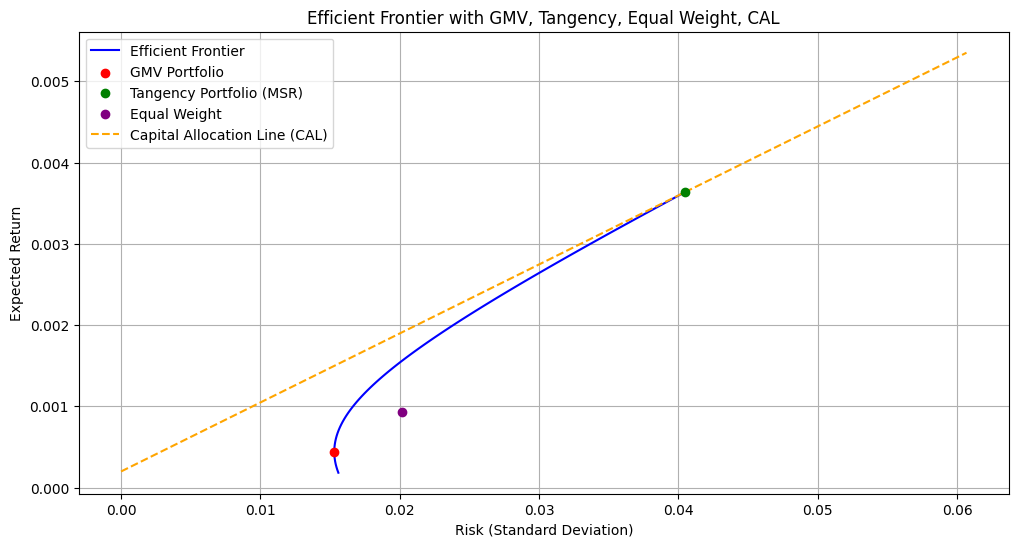

In [17]:
MPT.plot_frontier()

In [18]:
# Compute Global Minimum Variance Portfolio weights
GMV_weights = MPT.global_min_variance()
# GMV_weights

In [19]:
# Compute Maximum Sharpe Ratio Portfolio weights
MSR_weights = MPT.max_sharpe_ratio()
# MSR_weights

In [20]:
EW_weights = MPT.equal_weight()
# EW_weights

In [21]:
Mag7_test_ret = Mag7_Close_test.pct_change().dropna()

In [22]:
# Calculate strategy return as the dot product of weights and returns
Mag7_train_ret['MSR_strategy_ret'] = Mag7_train_ret.loc[:, :'TSLA'] @ MSR_weights
Mag7_train_ret['GMV_strategy_ret'] = Mag7_train_ret.loc[:, :'TSLA'] @ GMV_weights
Mag7_train_ret['EW_strategy_ret'] = Mag7_train_ret.loc[:, :'TSLA'] @ EW_weights

In [23]:
# Apply on the test set
Mag7_test_ret['MSR_strategy_ret'] = Mag7_test_ret.loc[:, :'TSLA'] @ MSR_weights
Mag7_test_ret['GMV_strategy_ret'] = Mag7_test_ret.loc[:, :'TSLA'] @ GMV_weights
Mag7_test_ret['EW_strategy_ret'] = Mag7_test_ret.loc[:, :'TSLA'] @ EW_weights

In [24]:
Mag7_train_ret.head(3)

Ticker,AAPL,AMZN,GOOG,META,MSFT,NVDA,TSLA,^GSPC,MSR_strategy_ret,GMV_strategy_ret,EW_strategy_ret
Date,,,,,,,,,,,
2021-01-05,0.012364,0.010004,0.007337,0.007548,0.000965,0.022210,0.007317,0.007083,0.029824,0.003847,0.009678
2021-01-06,-0.033662,-0.024897,-0.003234,-0.028269,-0.025929,-0.058953,0.028390,0.005710,-0.122572,-0.019970,-0.020936
2021-01-07,0.034123,0.007577,0.029943,0.020622,0.028457,0.057830,0.079447,0.014847,0.138889,0.024836,0.036857


In [25]:
Mag7_test_ret.head(3)

Ticker,AAPL,AMZN,GOOG,META,MSFT,NVDA,TSLA,^GSPC,MSR_strategy_ret,GMV_strategy_ret,EW_strategy_ret
Date,,,,,,,,,,,
2024-01-12,0.001778,-0.003609,0.003967,0.013039,0.009984,-0.002043,-0.036661,0.000751,0.039929,0.006951,-0.001935
2024-01-16,-0.012317,-0.009442,-0.001109,-0.018772,0.004634,0.030561,0.004660,-0.003731,0.127328,-0.009346,-0.000255
2024-01-17,-0.005174,-0.009467,-0.008259,0.002476,-0.002050,-0.005835,-0.019826,-0.005617,0.013656,-0.004406,-0.006876


In [26]:
# Backtest on the train set
MSR_train_perf_df, MSR_train_metrics = strategy_performance(df = Mag7_train_ret, strat_ret_col = 'MSR_strategy_ret',
                                                            risk_free = 0.05, market_returns = Mag7_train_ret['^GSPC'], plot = False)

GMV_train_perf_df, GMV_train_metrics = strategy_performance(df = Mag7_train_ret, strat_ret_col = 'GMV_strategy_ret',
                                                            risk_free = 0.05, market_returns = Mag7_train_ret['^GSPC'], plot = False)

EW_train_perf_df, EW_train_metrics = strategy_performance(df = Mag7_train_ret, strat_ret_col = 'EW_strategy_ret',
                                                          risk_free = 0.05, market_returns = Mag7_train_ret['^GSPC'], plot = False)

In [27]:
# Backtest on the test set
MSR_test_perf_df, MSR_test_metrics = strategy_performance(df = Mag7_test_ret, strat_ret_col = 'MSR_strategy_ret',
                                                risk_free = 0.05, market_returns = Mag7_test_ret['^GSPC'], plot = False)

GMV_test_perf_df, GMV_test_metrics = strategy_performance(df = Mag7_test_ret, strat_ret_col = 'GMV_strategy_ret',
                                                risk_free = 0.05, market_returns = Mag7_test_ret['^GSPC'], plot = False)

EW_test_perf_df, EW_test_metrics = strategy_performance(df = Mag7_test_ret, strat_ret_col = 'EW_strategy_ret',
                                              risk_free = 0.05, market_returns = Mag7_test_ret['^GSPC'], plot = False)

## **Strategy 2. Kelly Criterion**

In [29]:
# --- Kelly weights calculation ---
def kelly_weights(log_returns):
    mu = log_returns.mean().values
    cov = log_returns.cov().values
    inv_cov = np.linalg.pinv(cov)
    weights = inv_cov @ mu
    weights = np.clip(weights, 0, 1)
    weights /= weights.sum()
    return weights

# --- Rolling Kelly Strategy ---
def rolling_kelly(log_returns, window=252, rebalance_thresh=0.05):
    portfolio_log_returns = []
    current_weights = np.ones(log_returns.shape[1]) / log_returns.shape[1]
    rebalance_count = 0

    for i in range(window, len(log_returns)):
        train_data = log_returns.iloc[i - window:i]
        target_weights = kelly_weights(train_data)
        deviation = np.abs(target_weights - current_weights).max()

        if deviation > rebalance_thresh:
            current_weights = target_weights
            rebalance_count += 1

        r_t = log_returns.iloc[i].values
        portfolio_return = np.dot(current_weights, r_t)
        portfolio_log_returns.append(portfolio_return)

    return pd.Series(portfolio_log_returns, index=log_returns.index[window:]), rebalance_count

In [30]:
Mag7_Kelly_train =  Mag7_Close_train.copy()
Mag7_Kelly_test =  Mag7_Close_test.copy()

In [31]:
# TRAIN DATA

Mag7_Kelly_train.interpolate(method='linear', inplace=True)
Mag7_Kelly_train_logret = np.log(Mag7_Kelly_train).diff().dropna()

# Apply Kelly Strategy
Mag7_Kelly_train_portfolio, train_rebalance_count = rolling_kelly(Mag7_Kelly_train_logret)

# Convert to simple returns before performance analysis
Kelly_train_df = pd.DataFrame({'strategy_ret': np.exp(Mag7_Kelly_train_portfolio) - 1})

# Evaluate performance
Kelly_train_perf_df, Kelly_train_metrics_df = strategy_performance(Kelly_train_df, risk_free = 0.05, 
                                                                   market_returns = Mag7_train_ret['^GSPC'], plot = False)

In [32]:
# TEST DATA

Mag7_Kelly_test.interpolate(method='linear', inplace=True)
Mag7_Kelly_test_logret = np.log(Mag7_Kelly_test).diff().dropna()

# Apply Kelly Strategy
Mag7_Kelly_test_portfolio, test_rebalance_count = rolling_kelly(Mag7_Kelly_test_logret)

# Convert to simple returns before performance analysis
Kelly_test_df = pd.DataFrame({'strategy_ret': np.exp(Mag7_Kelly_test_portfolio) - 1})

# Evaluate performance
Kelly_test_perf_df, Kelly_test_metrics_df = strategy_performance(Kelly_test_df, risk_free = 0.05, 
                                                                 market_returns = Mag7_test_ret['^GSPC'], plot = False)

## **Strategy 3. Smart Beta**

In [34]:
def factor_investing_train_test(train_returns, train_prices, test_returns, test_prices, window=126):
    """
    Factor investing strategy: equally weight the top assets based on factor signal over a rolling window.
    """
    # Combine train + test for rolling signal computation
    all_returns = pd.concat([train_returns, test_returns], axis=0)
    
    # Create empty weight DataFrame
    weights = pd.DataFrame(0, index=all_returns.index, columns=all_returns.columns, dtype=float)

    # Rolling selection logic
    for i in range(window, len(all_returns)):
        past_returns = all_returns.iloc[i-window:i].mean()
        selected = past_returns.nlargest(3).index
        weights.loc[all_returns.index[i], selected] = 1 / len(selected)

    # Compute strategy return
    strategy_returns = (weights.shift(1) * all_returns).sum(axis=1)

    # Split into train and test
    train_strategy_returns = strategy_returns.loc[train_returns.index]
    test_strategy_returns = strategy_returns.loc[test_returns.index]
    
    train_weights = weights.loc[train_returns.index]
    test_weights = weights.loc[test_returns.index]

    return train_weights, train_strategy_returns, test_weights, test_strategy_returns

In [35]:
# Apply to test set
factor_train_weights, factor_train_ret, factor_test_weights, factor_test_ret = factor_investing_train_test(
    train_returns = Mag7_train_ret, train_prices = Mag7_Close_train, 
    test_returns = Mag7_test_ret, test_prices = Mag7_Close_test, 
    window = 126)


# Get output DF for backtesting 
factor_return_train = pd.DataFrame({'strategy_ret': factor_train_ret})
factor_return_test = pd.DataFrame({'strategy_ret': factor_test_ret})

In [36]:
# Evaluate performance on train
factor_train_perf_df, factor_train_metrics_df = strategy_performance(factor_return_train, risk_free = 0.05, 
                                                                     market_returns = Mag7_train_ret['^GSPC'], plot = False)

In [37]:
# Evaluate performance on test
factor_test_perf_df, factor_test_metrics_df = strategy_performance(factor_return_test, risk_free = 0.05, 
                                                                   market_returns = Mag7_test_ret['^GSPC'], plot = False)

## **Strategy 4. PCA_Based Rotation**

In [39]:
from sklearn.decomposition import PCA
from scipy.optimize import minimize

from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args

# Define PCA Rotation Strategy
def pca_rotation(returns, n_components=3, lookback=126, rebalance_freq=21, risk_aversion=1.0):
    weights = pd.DataFrame(index=returns.index, columns=returns.columns, dtype=float)

    for i in range(lookback, len(returns), rebalance_freq):
        window_returns = returns.iloc[i - lookback:i]

        pca = PCA(n_components=n_components)
        pca.fit(window_returns)
        loadings = pca.components_.T

        factors = pca.transform(window_returns)
        factor_rets = pd.DataFrame(factors, index=window_returns.index).pct_change().dropna()
        factor_cov = factor_rets.cov()

        def objective(w):
            port_ret = np.dot(w, factor_rets.mean())
            port_vol = np.sqrt(w @ factor_cov @ w)
            return - (port_ret - risk_aversion * port_vol**2)

        result = minimize(
            objective,
            x0=np.ones(n_components) / n_components,
            bounds=[(-1, 1)] * n_components,
            constraints={'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
        )

        factor_weights = result.x
        asset_weights = loadings @ factor_weights
        asset_weights /= np.sum(np.abs(asset_weights))

        end_idx = min(i + rebalance_freq, len(returns))
        weights.iloc[i:end_idx] = asset_weights

    return weights

# Optimization on train data
def optimize_parameters(train_data):
    space = [
        Integer(1, 5, name='n_components'),
        Integer(63, 252, name='lookback'),
        Integer(5, 63, name='rebalance_freq'),
        Real(0.5, 5.0, name='risk_aversion')
    ]

    @use_named_args(space)
    def objective(**params):
        weights = pca_rotation(train_data, **params)
        port_ret = (weights.shift(1) * train_data).sum(axis=1).dropna()
        sharpe = port_ret.mean() / port_ret.std() * np.sqrt(252)
        return -sharpe

    result = gp_minimize(objective, space, n_calls=40, random_state=42)
    return {
        'n_components': result.x[0],
        'lookback': result.x[1],
        'rebalance_freq': result.x[2],
        'risk_aversion': result.x[3]
    }

In [40]:
# Optimize PCA parameters on train
PCA_rotatation_best_params = optimize_parameters(Mag7_train_ret)
PCA_rotatation_best_params

{'n_components': 3, 'lookback': 85, 'rebalance_freq': 18, 'risk_aversion': 0.5}

In [41]:
# Apply on train
PCA_rotatation_weights_train = pca_rotation(Mag7_train_ret, **PCA_rotatation_best_params)
PCA_rotatation_train_returns = (PCA_rotatation_weights_train.shift(1) * Mag7_train_ret).sum(axis=1).dropna()
PCA_train_df = pd.DataFrame({'strategy_ret': PCA_rotatation_train_returns})

In [42]:
# Apply on test
PCA_rotatation_weights_test = pca_rotation(Mag7_test_ret, **PCA_rotatation_best_params)
PCA_rotatation_test_returns = (PCA_rotatation_weights_test.shift(1) * Mag7_test_ret).sum(axis=1).dropna()
PCA_test_df = pd.DataFrame({'strategy_ret': PCA_rotatation_test_returns})

In [43]:
# Evaluate performance on train
PCA_rotation_train_perf_df, PCA_rotation_train_metrics_df = strategy_performance(PCA_train_df, risk_free = 0.05, 
                                                                                 market_returns = Mag7_train_ret['^GSPC'], plot = False)

In [44]:
# Evaluate performance on test
PCA_rotation_test_perf_df, PCA_rotation_test_metrics_df = strategy_performance(PCA_test_df, risk_free = 0.05, 
                                                                               market_returns = Mag7_test_ret['^GSPC'], plot = False)

## **5. Compare strategies**

In [46]:
# TRAIN DATA
P_train = pd.concat([
    MSR_train_metrics,
    GMV_train_metrics,
    EW_train_metrics,
    Kelly_train_metrics_df,
    factor_train_metrics_df,
    PCA_rotation_train_metrics_df
], axis = 1)

P_train.columns = ['MPT_Tangency', 'MPT_GMV', 'MPT_EqualW', 'Kelly', 'SmartBeta', 'PCA_rotation']
P_train

,MPT_Tangency,MPT_GMV,MPT_EqualW,Kelly,SmartBeta,PCA_rotation
Strategy Cum Ret,22.0481,0.2782,0.7445,0.1684,3.1597,10.1080
Market Cum Ret,0.2926,0.2926,0.2926,-0.0027,0.2926,0.2926
Annualized Return,1.8847,0.1110,0.2358,0.1338,0.6201,0.8784
Annualized Std,1.3327,0.2429,0.3195,0.3364,0.5518,0.3996
Annualized Sharpe,1.3767,0.2509,0.5815,0.2491,1.0332,2.0731
Beta (CAPM),2.8415,1.0748,1.5849,1.4896,1.6655,0.8107
Alpha (CAPM),1.5988,0.0028,0.0763,0.1078,0.4525,0.7968
Treynor Ratio,0.6457,0.0567,0.1172,0.0563,0.3423,1.0218
Max Drawdown,-0.9509,-0.2895,-0.4950,-0.4275,-0.6075,-0.2339


In [47]:
# TEST DATA
P_test = pd.concat([
    MSR_test_metrics,
    GMV_test_metrics,
    EW_test_metrics,
    Kelly_test_metrics_df,
    factor_test_metrics_df,
    PCA_rotation_test_metrics_df
], axis = 1)

P_test.columns = ['MPT_Tangency', 'MPT_GMV', 'MPT_EqualW', 'Kelly', 'SmartBeta', 'PCA_rotation']
P_test

,MPT_Tangency,MPT_GMV,MPT_EqualW,Kelly,SmartBeta,PCA_rotation
Strategy Cum Ret,0.1831,-0.0722,0.3638,-0.1434,1.4125,-0.0453
Market Cum Ret,0.1650,0.1650,0.1650,-0.0469,0.1650,0.1650
Annualized Return,1.3484,-0.0297,0.2872,-0.4167,0.8918,0.0222
Annualized Std,1.5122,0.2394,0.3069,0.4944,0.6502,0.3447
Annualized Sharpe,0.8586,-0.3328,0.7729,-0.9441,1.2946,-0.0808
Beta (CAPM),2.7544,0.8686,1.5461,1.6085,2.2159,1.2227
Alpha (CAPM),0.9782,-0.1464,0.0794,-0.2191,0.5940,-0.1422
Treynor Ratio,0.4714,-0.0917,0.1534,-0.2902,0.3799,-0.0228
Max Drawdown,-0.9024,-0.2747,-0.2899,-0.3050,-0.4045,-0.3370
